In [2]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import glob
import matplotlib.pyplot as plt
from time import strftime

In [3]:
def get_bkg_features(sets_of_npzs, weights, mz400_template, mz400_xsec, n_target_events=30000, n_template = 2000):
    """
    Gets a combined, weighted combination of events
    """
    weights /= np.sum(weights) # normalize
    mz400_xsec /= np.sum(mz400_xsec)
    print(f'weights: {weights}')
    n_events_per_set = (weights * n_target_events).astype(np.int32)
    nsig_events_per_set = (mz400_xsec *n_template).astype(np.int32)
    print(f'n_events per set: {n_events_per_set}')
    
    # this section to produce the signal pt histogram 
    #I used the mz'=400 as the template histogram    
    for ns_events, nsig_pzs in zip(nsig_events_per_set, mz400_template):
        n_events_todo = ns_events
        mz400_comb = []        
        for npz in nsig_pzs:
            X = np.load(npz)['X'][:,:12]
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]
            mz400_comb.append(X)
    mz400_final = np.vstack(mz400_comb)
    pt_sig = mz400_final[:,11]
    
    W_pt = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        n_events_todo = n_events
        for npz in npzs:
            X = np.load(npz)['X'][:,:12]
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]    
            pt = []
            pt_qcd = np.load(npz)['X'][:,11] 
            fig = plt.figure(figsize=(6,6))
            ax1 = fig.gca()
            pt.append(pt_qcd)
            pt.append(pt_sig)
            ns, bins, patches = ax1.hist(pt, bins=50, alpha=0.2, range=[100,1500], label=['qcd','sig'])
            ax1.legend()
            
            w_pt = np.zeros((n_events_this_npz,1))
            for i in range(len(pt_qcd)):
              for j in range(len(ns[1])):
               if bins[j]<pt_qcd[i] and bins[j+1]>pt_qcd[i] and ns[1,j] > 0:
                w_pt[i] = ((ns[1][j]/ns[0][j]))              
            if n_events_this_npz > n_events_todo:
                w_pt = w_pt[:n_events_todo]
            W_pt.append(w_pt)          
            plt.close() #to close the display of the figures --> avoid memory intensive job
            n_events_todo -= X.shape[0]
            if n_events_todo == 0: break        
        else:
            print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')

    wpt_final = np.vstack(W_pt)

    X_COM = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        n_events_todo = n_events*wpt_final
        for npz in npzs:
            X = np.load(npz)['X'][:,:9]
            n_events_this_npz = X.shape[0]*wpt_final
            if n_events_this_npz.any() > n_events_todo.any():
                X = X[:n_events_todo]
            X_COM.append(X)
            if n_events_todo.any() == 0: break        
        #else:
        #    print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')
    X_FIN = np.vstack(X_COM)
    assert len(X_FIN.shape) == 2
    assert X_FIN.shape[1] == 9
    print(f'shape of X_FIN: {X_FIN.shape}')
    
    #print(f'X_final: {X_final[1,:9]}')
    print(f'X_FIN value: {X_FIN[1,:9]}')
    return X_FIN



In [4]:
labels = ['QCD_Pt_300to470', 'QCD_Pt_470to600', 'QCD_Pt_600to800', 'QCD_Pt_800to1000', 'QCD_Pt_1000to1400']
#need to add selection efficiency
crosssections = [6826.0*0.0023, 552.6*0.0442, 156.6*0.0656, 26.32*0.0516, 7.50*0.0438]
sets_of_npzs = [ glob.iglob(f'/home/snabili/data/bdt/svj-bdt/my_codes/parton_flavor/prebdt_Nov15/*{l}*/*.npz') for l in labels ]
lab = ['mz400']
sig_benchmark = [glob.iglob(f'/home/snabili/data/bdt/svj-bdt/my_codes/parton_flavor/prebdt_Nov15/*{l}*/*.npz') for l in lab]
benchmark_weight = [1]
X_bkg = get_bkg_features(sets_of_npzs, crosssections, sig_benchmark, benchmark_weight)
y_bkg = np.zeros(X_bkg.shape[0])

weights: [0.30143061 0.46894983 0.1972372  0.02607527 0.00630708]
n_events per set: [ 9042 14068  5917   782   189]
shape of X_FIN: (1419833, 9)
X_FIN value: [ 2.77706295e-01  5.91383055e-02  6.30000000e+01  1.52876526e-01
  3.89953814e-02 -2.28401772e-01  1.15331918e-01  2.00300646e+00
  2.10606176e-02]


In [5]:
def get_sig_features(sets_of_npzs, weights, n_target_events=2000):
    """
    Gets a combined, weighted combination of events
    """
    weights /= np.sum(weights) # normalize
    print(f'weights: {weights}')
    n_events_per_set = (weights * n_target_events).astype(np.int32)

    print(f'n_events per set: {n_events_per_set}')

    X_combined = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        print(f'n_events: {n_events}')
        n_events_todo = n_events
        for npz in npzs:
            X = np.load(npz)['X'][:,:9]
            #X = np.load(npz)
            #print('X is: ', X)
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]
            X_combined.append(X)
            n_events_todo -= X.shape[0]
            if n_events_todo == 0: break
        else:
            print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')

    X_final = np.vstack(X_combined)
    assert len(X_final.shape) == 2
    assert X_final.shape[1] == 9
    return X_final

In [6]:
labels_sig = ['mz250', 'mz300', 'mz350', 'mz400', 'mz450']
sig_xsec = [1,1,1,1]
sig_npzfiles = [ glob.iglob(f'/data/users/snabili/bdt/svj-bdt/data/signal/*{l}*/*.npz') for l in labels_sig ]
#labels_sig = ['mz400']
#sig_xsec = [1]
#sig_npzfiles = [glob.iglob(f'/home/snabili/data/bdt/svj-bdt/my_codes/parton_flavor/prebdt_Nov15/*{l}*/*.npz') for l in labels_sig]
X_signal = get_sig_features(sig_npzfiles, sig_xsec)
y_signal = np.ones(X_signal.shape[0])

weights: [0.25 0.25 0.25 0.25]
n_events per set: [500 500 500 500]
n_events: 500
n_events: 500
n_events: 500
n_events: 500


In [7]:
X = np.vstack((X_signal, X_bkg))
y = np.concatenate((y_signal, y_bkg)).astype(np.int8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

In [8]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [9]:
model = xgb.XGBClassifier(
    eta=.03, scale_pos_weight=y.shape[0]/np.sum(y),
    max_depth=4,
    n_estimators=1000,
    eval_metric='logloss',
    #use_label_encoder=False
    )
model.fit(X_train, y_train)

/home/snabili/miniconda3/envs/svj-bdt/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0299999993,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=710.9165, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)

array([[255158,  28827],
       [    80,    302]])

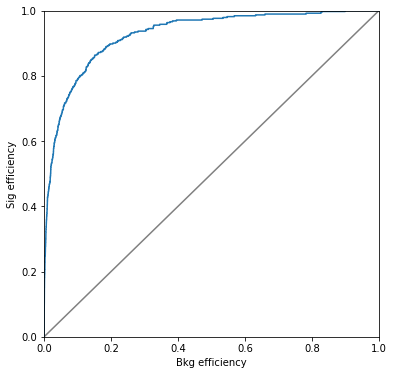

In [11]:
eff_bkg, eff_sig, cuts = roc_curve(y_test, y_prob)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.plot([0,1], [0,1], c='gray')
ax.plot(eff_bkg, eff_sig)
ax.set_ylim(0., 1.)
ax.set_xlim(0., 1.)
ax.set_xlabel('Bkg efficiency')
ax.set_ylabel('Sig efficiency')
fig.savefig('bdt_roccurve.pdf')

In [12]:
i_wp = np.argmax(eff_bkg >= .05)
print(f'eff_sig: {eff_sig[i_wp]:.3f}, bkg_eff: {eff_bkg[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

i_wp = np.argmax(eff_bkg >= .31)
print(f'eff_sig: {eff_sig[i_wp]:.3f}, bkg_eff: {eff_bkg[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

eff_sig: 0.675, bkg_eff: 0.050, cut: 0.705
eff_sig: 0.942, bkg_eff: 0.311, cut: 0.107


In [13]:
model.save_model(strftime('svjbdt_%b%d.json'))

In [14]:
auc(eff_bkg, eff_sig)

0.9279363531017557

In [15]:
y_prob_sig = y_prob[y_test == 1]
y_prob_bkg = y_prob[y_test == 0]

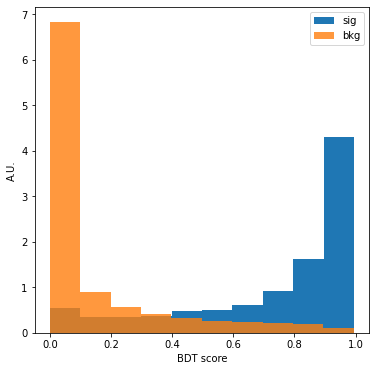

In [16]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

ax.hist(y_prob_sig, label='sig', density=True, bins=10)
ax.hist(y_prob_bkg, label='bkg', alpha=.8, density=True, bins=10)
ax.legend()
ax.set_ylabel('A.U.')
ax.set_xlabel('BDT score')
fig.savefig('bdtscores_allsig.png')
fig.savefig('bdtscores_allsig.pdf')

In [19]:
corrmat = np.corrcoef(X)
corrmat = np.corrcoef(X.T)

MemoryError: Unable to allocate 14.7 TiB for an array with shape (1419351, 1419351) and data type float64

In [ ]:
corrmat.shape

In [ ]:
labels = ['girth', 'ptD', 'axismajor', 'axisminor', 'ecfM2b1', 'ecfD2b1', 'ecfC2b1', 'ecfN2b2', 'metdphi', 'multiplicity', 'paton_flavor']
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
mshow = ax.matshow(corrmat, cmap=plt.cm.Reds)
ax.set_xticklabels(['']+labels, rotation=90)
ax.set_yticklabels(['']+labels)
fig.savefig('correlationmatrix.pdf')

cbar = fig.colorbar(mshow)
cbar
y_prob_sig.dtype = [('y_prob_sig', 'float32')]
y_prob_bkg.dtype = [('y_prob_bkg', 'float32')]

In [ ]:
import numpy as np
#data = np.load("../data/signal.npz")
#data.files
data = np.load("../data/signal.npz")['X'][:,:1]
data
#print(f'data first item is: {data.items()}')
#data[0]
#print('*'*50)
#data[1]
#all = [('data', 'float32')]
#y_prob_bkg.dtype = [('y_prob_bkg', 'float32')]
#array2root(all, "test.root", "tree1")

In [ ]:
plt.cm.Reds

## Check model IO

In [ ]:
model2 = xgb.XGBClassifier()
model2.load_model('svjbdt_Nov12.json')

In [ ]:
bdt = model2.predict_proba(X_test)

In [ ]:
plt.hist(bdt)

In [ ]:
model2.predict_proba(X_train[:2])